In [1]:
import sys
import os

parent_dir = os.path.abspath(os.path.join(os.path.abspath(''), os.pardir, os.pardir, os.pardir))
sys.path.append(parent_dir)

from misc.vae import load_VAE
from vae import FluxVAE

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

# Data generation

In [2]:
# This just sets up the code to load a VAE (which is already implemented in ./misc/)

def get_vae(k):
    return load_VAE(f"models/k{k}/")

ks = [100, 250, 500, 1000, 2500]

vaes = {
    k : get_vae(k)
    for k in ks
}

vaes

Loading model...
Encoder path -> models/k100/encoder_testmin.pth
Decoder path -> models/k100/decoder_testmin.pth
Desc path    -> models/k100/vae_desc_testmin.json


Loading model...
Encoder path -> models/k250/encoder_testmin.pth
Decoder path -> models/k250/decoder_testmin.pth
Desc path    -> models/k250/vae_desc_testmin.json
Loading model...
Encoder path -> models/k500/encoder_testmin.pth
Decoder path -> models/k500/decoder_testmin.pth
Desc path    -> models/k500/vae_desc_testmin.json
Loading model...
Encoder path -> models/k1000/encoder_testmin.pth
Decoder path -> models/k1000/decoder_testmin.pth
Desc path    -> models/k1000/vae_desc_testmin.json
Loading model...
Encoder path -> models/k2500/encoder_testmin.pth
Decoder path -> models/k2500/decoder_testmin.pth
Desc path    -> models/k2500/vae_desc_testmin.json


{100: <vae.FluxVAE at 0x7fb44d400610>,
 250: <vae.FluxVAE at 0x7fb44d3b7c10>,
 500: <vae.FluxVAE at 0x7fb44d4003d0>,
 1000: <vae.FluxVAE at 0x7fb35601b070>,
 2500: <vae.FluxVAE at 0x7fb44c256c20>}

In [3]:
# The samples folder is set up to contain samples files created using the flux_processor (in ./tools/)

def load_data(k):
    return pd.read_csv(f"samples/k{k}_test_pre.csv")

In [4]:
# This used the get_loss function implemented in FluxVAE. Since we have already taking V using the VAE's 
# reaction names there is no need to find a new conversion matrix as in the rest of the codebase. Similarly,
# the stoichiometric loss functionality is being ignored here so S is simply passed as a 0 matrix.

def get_loss(df, vae : FluxVAE):
    n_in = len(vae.reaction_names)
    V = df[vae.reaction_names].values
    C = np.eye(5399)
    S = np.eye(5399) * 0
    _, blame = vae.get_loss(V, C, S)
    return blame

In [5]:
loss_types = ["loss", "divergence_loss", "reconstruction_loss"]

columns = sum([[
        f"k{k}_{loss_type}"
    for loss_type in loss_types
    ]
    for k in ks
], start=[])


In [6]:
# This simply find the loss for each VAE and sample (differentiated in both cases by step-size k).

data = np.zeros((len(ks), len(columns)))

for j, test_k in enumerate(ks):
    print("test_k", test_k)
    test_df = load_data(test_k)
    for i, train_k in enumerate(ks):
        print("train_k", train_k)
        blame = get_loss(test_df, vaes[train_k])
        for l in range(3): 
            data[i,3*j + l] = blame[loss_types[l]]

df = pd.DataFrame(data, columns=columns)

test_k 100
train_k 100
train_k 250
train_k 500
train_k 1000
train_k 2500
test_k 250
train_k 100
train_k 250
train_k 500
train_k 1000
train_k 2500
test_k 500
train_k 100
train_k 250
train_k 500
train_k 1000
train_k 2500
test_k 1000
train_k 100
train_k 250
train_k 500
train_k 1000
train_k 2500
test_k 2500
train_k 100
train_k 250
train_k 500
train_k 1000
train_k 2500


In [ ]:
# For a while a constant term wasn't included in the loss, this was uncommented for that case.

#for col in columns:
#    if "divergence" in col or "0_loss" in col:
#        df[col] -= 32 / 2

In [8]:
# The dataset is saved to speed up future analysis (i.e. plotting).

df.to_csv("k_test_train_losses.csv")

# Plotting
This section contains the plotting code.

In [10]:
df = pd.read_csv("k_test_train_losses.csv")

In [11]:
loss_cols = [col for col in columns if "0_loss" in col]
div_cols = [col for col in columns if "divergence" in col]
rec_cols = [col for col in columns if "reconstruction" in col]

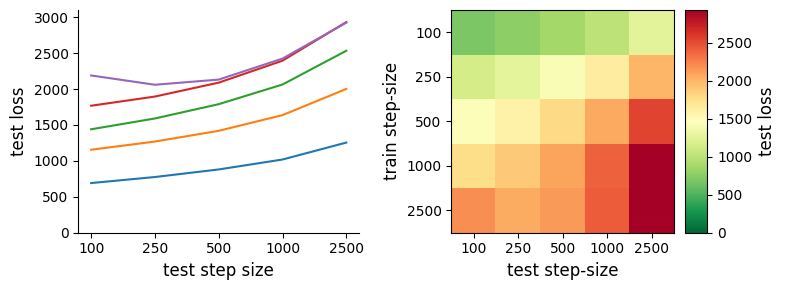

In [12]:
fontsize=12

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))

x = np.arange(len(ks))
y = np.arange(len(ks))

def hm_plot(ax):
    im = ax.imshow(df[loss_cols].values, cmap='RdYlGn_r', vmin=0)

    ax.set_xlabel("test step-size", fontsize=fontsize)
    ax.set_ylabel("train step-size", fontsize=fontsize)


    ax.set_xticks(x, ks)
    ax.set_yticks(y, ks)

    loc = make_axes_locatable(ax)
    cax = loc.append_axes("right", size="10%", pad="5%")

    cb = plt.colorbar(im, cax=cax)
    cb.set_label("test loss", fontsize=fontsize)

def line_plot(ax):
    for i in range(len(ks)):
        ax.plot(np.arange(len(ks)), df.iloc[i][loss_cols].values, label=ks[i])

    #ax.legend()
    ax.set_xlabel("test step size", fontsize=fontsize)
    ax.set_ylabel("test loss", fontsize=fontsize)
    ax.spines[["top", "right"]].set_visible(False)
    ax.set_ylim([0, 3100])
    ax.set_xticks(x, ks)

line_plot(ax1)
hm_plot(ax2)

fig.tight_layout()

fig.savefig("cross_k_test_loss.png", dpi=600)